In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import gaussian_process
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle
from scipy import interpolate
import tensorflow as tf

In [168]:
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())

#Evaluation for binary classification
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_pred[index_p] == 1).sum()
    false_positif = (y_pred[index_n] == 1).sum()

    true_negatif = (y_pred[index_n] == 0).sum()
    false_negatif = (y_pred[index_p] == 0).sum()

    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    precision = true_positif/(true_positif + false_positif + K.epsilon())
    recall = true_positif/(true_positif + false_negatif + K.epsilon())
    f_score = (2*precision*recall)/(precision+recall + K.epsilon())
    
    return precision, recall,f_score, m


In [250]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    tau, epsilon, Prot, amp = params_act
    k = gaussian_process.kernels.RBF(tau)
    k*= gaussian_process.kernels.ExpSineSquared(np.sqrt(epsilon),Prot)
    k*= amp**2
    
    gp = gaussian_process.GaussianProcessRegressor(k)
    t_gp = np.reshape(t, (t.shape[0],1))

    yact = gp.sample_y(t_gp, n_samples = 100)[:,np.random.randint(0,100)]
    
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc=3,scale=0.30, size=len(t)) # m/s
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    return ytot, eb




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def generate_data(t,dt,Ttot,freq,params_gp, params_gr,params_pl, nbr_pl_to_inject):
    
    # Generate H0 data, activity signal 
    y_noise, eb = generate_data_H0(params_gr, params_gp, t)
    
    #Without planet 
    if ( nbr_pl_to_inject == 0):
        GLS = LombScargle(t, y_noise,eb).power(freq,method='cython')
        label = 0
        max_value = np.array([freq[np.argmax(GLS)],np.max(GLS)])
        Ppl = 0
        
    #With planet
    else :
        # Add the planet signal to noise and other planetary signal
        y_pl = generate_planete(params_pl, t)
        y_i = y_noise + y_pl 
        
        # Create GLS
        GLS = LombScargle(t, y_i,eb).power(freq,method='cython')
        max_value = np.array([freq[np.argmax(GLS)],np.max(GLS)])
        if ( np.isclose(1/params_pl[0], max_value[0], atol=0.002) ): 
            # case where best_freq (max of GLS) is corresponding to any frequency planet
            label = 1
        else:
            label = 0
            
        
    return GLS, label, max_value



def generate_time(Ttot):
    #Generate time and frequency
    #Over-sampling
    facteur_surech = 10
    N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
    t_over = np.linspace(0,Ttot,N) #days
    
    # Irregular sampling 1 : with normal distribution
    facteur_ech = 20
    t = np.zeros(Ttot)

    ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[0] = t_over[ ind0 ]
    ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[-1] = t_over[ ind_fin ]

    pas = N/Ttot
    for i in range(Ttot-2):
        ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
        t[i+1] =  t_over[ind]

    dt = np.median(np.diff(t))
    fmin = 1/(t[-1]-t[0])
    fmax = (1/dt)/2 
    freq = np.linspace(fmin,fmax,990)
    
    return freq, t,dt

In [251]:
Ttot = 200
freq, t, dt= generate_time(Ttot)

A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz
params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

In [267]:
N = 5000
GLS_H0 = np.zeros((N,freq.shape[0]))

#Params_GP
Prot = 15 #random.randint(5,90)
amp  = 2#gamma.rvs(2.0, 0.5) 
epsilon = 0.5#uniform.rvs(0.5, 1)
tau = 2*Prot#np.random.normal(3*Prot, 0.1*Prot)
params_gp = [tau, epsilon, Prot, amp]

for i in range(N):
    GLS, label, Maxs = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl,0)
    GLS_H0[i,:] = GLS

In [268]:
GLS_mean_H0 = np.mean(GLS_H0, axis = 0) 

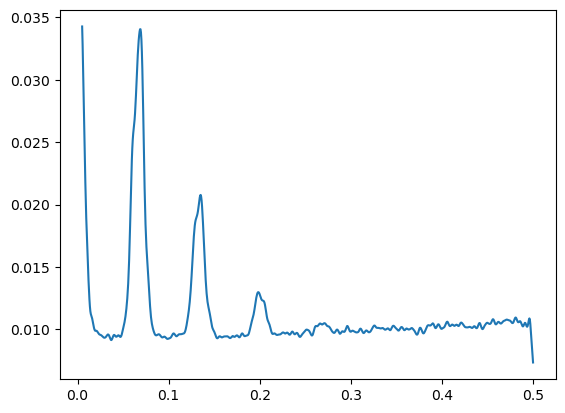

In [269]:
plt.plot(freq,GLS_mean_H0)

## Test

In [263]:
N_test = 1000
GLS_test1, Label_test1, Maxs_test1 = np.zeros((N_test,freq.shape[0])), np.zeros(N_test), np.zeros((N_test,2))
GLS_test2, Label_test2, Maxs_test2 = np.zeros((N_test,freq.shape[0])), np.zeros(N_test), np.zeros((N_test,2))

In [270]:
#Params_first planet signal 
Ppl1= 5#random.uniform(10*dt,Ttot/2) 
A1 = 1#loguniform.rvs(0.1, 10)
T01 = random.uniform(0,Ppl1) #random.uniform(0,Ppl)
params_pl1 = [Ppl1,A1,T01]

#Params second planet signal
Ppl2= 20#random.uniform(10*dt,Ttot/2) 
A2 = 1#loguniform.rvs(0.1, 10)
T02 = random.uniform(0,Ppl2) #random.uniform(0,Ppl)
params_pl2 = [Ppl2,A2,T02]

for i in range(round(N_test/2)):
    GLS, label, Maxs = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl1,1)
    GLS_test1[i,:] = GLS
    Maxs_test1[i,:] = Maxs
    Label_test1[i] = label
    
    GLS, label, Maxs = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl2,1)
    GLS_test2[i,:] = GLS
    Maxs_test2[i,:] = Maxs
    Label_test2[i] = label
    
for k in range(round(N_test/2),N_test):
    GLS, label, Maxs = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl1,0)
    GLS_test1[k,:], GLS_test2[k,:] = GLS, GLS
    Maxs_test1[k,:],Maxs_test2[k,:] = Maxs, Maxs
    Label_test1[k], Label_test2[k] = label, label

In [271]:
#First test, take the maximum and compared to a threshold
Maxs11 = Maxs_test1[:,1]
Maxs12 = Maxs_test2[:,1]
#Second test, divide GLS_test by mean_GLS under H0, and take the max
Maxs21 = np.max(GLS_test1 / GLS_mean_H0, axis = 1)
Maxs22 = np.max(GLS_test2 / GLS_mean_H0, axis = 1)

Text(0, 0.5, 'Pdet')

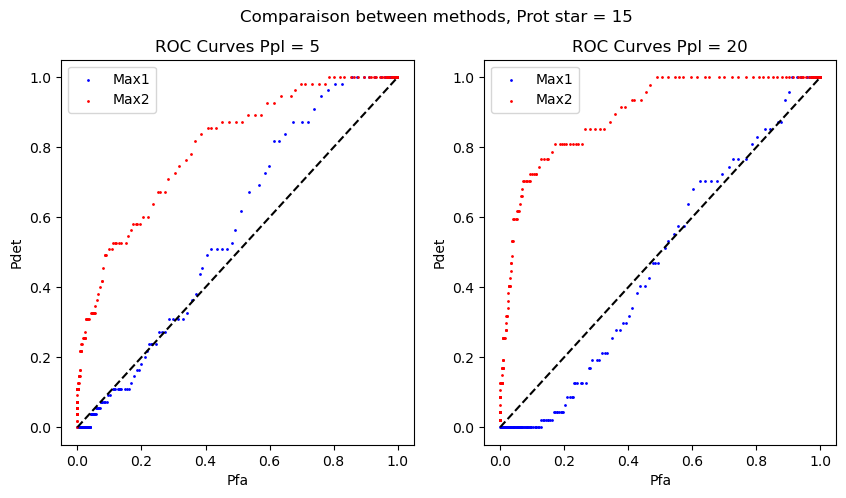

In [274]:
#Comparaison between cnn and max test normalized by h0 distribution on fixed GP parameters data 
N = 200
threshold_max11 = np.linspace(np.min(Maxs11),np.max(Maxs11),N)
threshold_max12 = np.linspace(np.min(Maxs12),np.max(Maxs12),N)

threshold_max21 = np.linspace(np.min(Maxs21),np.max(Maxs21),N)
threshold_max22 = np.linspace(np.min(Maxs22),np.max(Maxs21),N)

Pdet11, Pfa11 = np.zeros(N), np.zeros(N)
Pdet12, Pfa12 = np.zeros(N), np.zeros(N)
Pdet21, Pfa21 = np.zeros(N), np.zeros(N)
Pdet22, Pfa22 = np.zeros(N), np.zeros(N)

for i in range(N):
    y_seuil = np.where(Maxs11 > threshold_max11[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test1)
    Pdet11[i], Pfa11[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs12 > threshold_max12[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test2)
    Pdet12[i], Pfa12[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    y_seuil = np.where(Maxs21 > threshold_max21[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test1)
    Pdet21[i], Pfa21[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs22 > threshold_max22[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test2)
    Pdet22[i], Pfa22[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])

    
plt.figure(figsize=(10,5))
plt.suptitle("Comparaison between methods, Prot star = 15\n")
plt.subplot(121)
plt.title("ROC Curves Ppl = 5")
plt.scatter(Pfa11, Pdet11, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa21, Pdet21, label='Max2', s=1, c='r'),plt.legend()
plt.plot(x_interp,x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

plt.subplot(122)
plt.title("ROC Curves Ppl = 20")
plt.scatter(Pfa12, Pdet12, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa22, Pdet22, label='Max2', s=1, c='r'),plt.legend()
plt.plot(x_interp,x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

## CNN

In [ ]:
#Data train
N = 5000
GLS = np.zeros((N,freq.shape[0]))
for i in range(N):
    GLS, label, Maxs = generate_data(t,dt,Ttot,freq,params_gr, params_pl,0)
    GLS_H0[i,:] = GLS
    